In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout, Masking
from tensorflow.keras import optimizers, losses, activations
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Bidirectional, LSTM, GRU, BatchNormalization,
    Dropout, Dense
)
from tensorflow.keras.utils import to_categorical

In [2]:
# Load sets
save_dir = "/content/drive/MyDrive/mitbih_processed_splits"

train_data = np.load(os.path.join(save_dir, "train_set.npz"))
val_data   = np.load(os.path.join(save_dir, "val_set.npz"))
test_data  = np.load(os.path.join(save_dir, "test_set.npz"))

X_train, y_train = train_data["X"], train_data["y"]
X_val,   y_val   = val_data["X"], val_data["y"]
X_test,  y_test  = test_data["X"], test_data["y"]

# Map labels to integers
label_mapping = {'N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4}

y_train = np.array([label_mapping[label] for label in y_train])
y_val   = np.array([label_mapping[label] for label in y_val])
y_test  = np.array([label_mapping[label] for label in y_test])

# Prepare labels
num_classes = 5
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)
y_test_cat = to_categorical(y_test, num_classes)

# Reshape inputs
X_train_rnn = X_train[..., np.newaxis]
X_val_rnn   = X_val[..., np.newaxis]
X_test_rnn  = X_test[..., np.newaxis]

print("RNNs input shape:", X_train_rnn.shape) # (samples, timesteps, features) → 360 timesteps and 1 feature (ECG amplitude)

RNNs input shape: (38572, 360, 1)


##**Using R-peak segments**

###**BiLSTM**

Create model and compile it.

In [20]:
save_dir = "/content/drive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "BiLSTM_64x2.keras")

# Create BiLSTM architecture
model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(360, 1)))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Bidirectional(LSTM(64)))
model_bilstm.add(Dropout(0.1))
model_bilstm.add(Dense(5, activation='softmax'))

# Compile model
opt = optimizers.Adam(learning_rate=0.001)
model_bilstm.compile(
    optimizer=opt,
    loss=losses.categorical_crossentropy,
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max",
                      patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", mode="max",
                              patience=5, factor=0.5, verbose=2)

callbacks_list = [checkpoint, early, reduce_lr]

# Summary
model_bilstm.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_12                │ (None, 360, 128)       │        33,792 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 360, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 128)            │        98,816 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133,253 (520.52 KB)

 Trainable params: 133,253 (520.52 KB)

 Non-trainable params: 0 (0.00 B)

Train for 30 epochs using early stopping.

In [21]:
history_bilstm = model_bilstm.fit(
    X_train_rnn, y_train_cat,
    validation_data=(X_val_rnn, y_val_cat),
    epochs=30,
    batch_size=128,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5712 - loss: 1.1362
Epoch 1: val_accuracy improved from -inf to 0.83401, saving model to /content/drive/MyDrive/Models/BiLSTM_64x2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - accuracy: 0.5715 - loss: 1.1352 - val_accuracy: 0.8340 - val_loss: 0.5470 - learning_rate: 0.0010
Epoch 2/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.5159 - loss: 1.2504
Epoch 2: val_accuracy did not improve from 0.83401
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.5160 - loss: 1.2499 - val_accuracy: 0.7993 - val_loss: 0.7388 - learning_rate: 0.0010
Epoch 3/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5773 - loss: 1.0830
Epoch 3: val_accuracy did not improve from 0.83401
302/302 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.5773 - loss: 1.0829 - val_accuracy: 0.7988 - val_loss: 0.7151 - learning_rate: 0.0010
Epoch 4/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5823 - loss: 1.0510
Epoc

Plot learning curves.

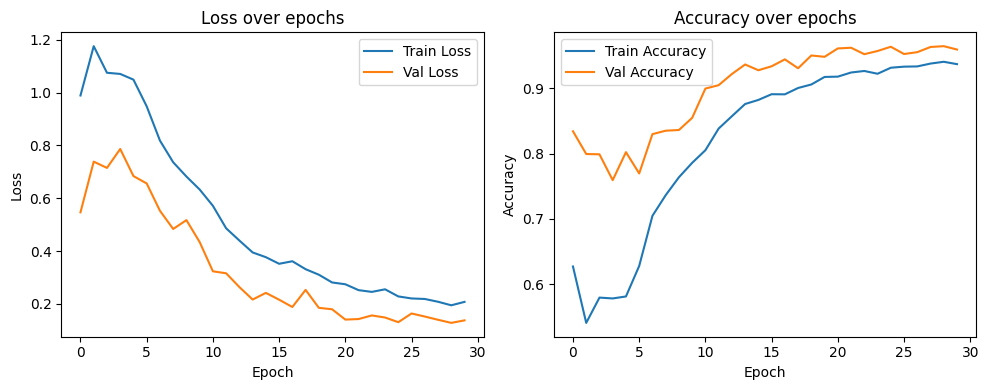

In [22]:
plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history_bilstm.history['loss'], label='Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_bilstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_bilstm.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Evaluate on test set.

In [26]:
# Predict on test set
y_pred_probs = model_bilstm.predict(X_test_rnn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report
print("Classification Report (BiLSTM):\n")
print(classification_report(
    y_true, y_pred,
    target_names=["N", "S", "V", "F", "Q"],
    digits=4
))

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step
Classification Report (BiLSTM):

              precision    recall  f1-score   support

           N     0.9836    0.9737    0.9786      9059
           S     0.8040    0.7230    0.7614       278
           V     0.8731    0.8949    0.8839       723
           F     0.5263    0.7500    0.6186        80
           Q     0.9162    0.9713    0.9430      1115

    accuracy                         0.9606     11255
   macro avg     0.8207    0.8626    0.8371     11255
weighted avg     0.9622    0.9606    0.9611     11255



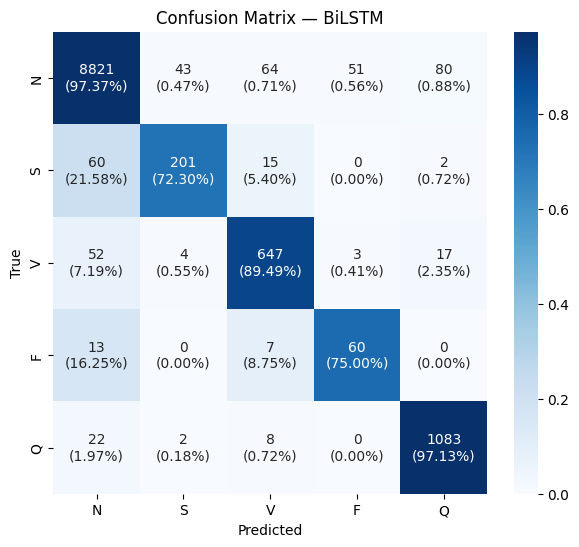

In [27]:
# Confusion matrix
cm_counts = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

labels = np.asarray([
    [f"{count}\n({percent*100:.2f}%)" for count, percent in zip(row_counts, row_norm)]
    for row_counts, row_norm in zip(cm_counts, cm_norm)
])

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=labels, fmt="", cmap="Blues",
            xticklabels=["N", "S", "V", "F", "Q"],
            yticklabels=["N", "S", "V", "F", "Q"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — BiLSTM")
plt.show()

###**BiGRU**

In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Bidirectional, Dense, Dropout
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os

# === Paths ===
save_dir = "/content/drive/MyDrive/Models"
os.makedirs(save_dir, exist_ok=True)
file_path = os.path.join(save_dir, "BiGRU_64x2.keras")

# Create BiGRU architecture
model_bigru = Sequential()
model_bigru.add(Bidirectional(GRU(64, return_sequences=True), input_shape=(360, 1)))
model_bigru.add(Dropout(0.1))
model_bigru.add(Bidirectional(GRU(64)))
model_bigru.add(Dropout(0.1))
model_bigru.add(Dense(5, activation='softmax'))

# Compile
opt = optimizers.Adam(learning_rate=0.001)
model_bigru.compile(
    optimizer=opt,
    loss=losses.categorical_crossentropy,
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint(file_path, monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_accuracy", mode="max",
                      patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", mode="max",
                              patience=5, factor=0.5, verbose=2)

callbacks_list = [checkpoint, early, reduce_lr]

model_bigru.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_14                │ (None, 360, 128)       │        25,728 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 360, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_15                │ (None, 128)            │        74,496 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,869 (394.02 KB)

 Trainable params: 100,869 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
history_bigru = model_bigru.fit(
    X_train_rnn, y_train_cat,
    validation_data=(X_val_rnn, y_val_cat),
    epochs=30,
    batch_size=128,
    verbose=1,
    callbacks=callbacks_list
)

Epoch 1/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.5609 - loss: 1.1710
Epoch 1: val_accuracy improved from -inf to 0.81100, saving model to /content/drive/MyDrive/Models/BiGRU_64x2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 23s 67ms/step - accuracy: 0.5611 - loss: 1.1704 - val_accuracy: 0.8110 - val_loss: 0.6782 - learning_rate: 0.0010
Epoch 2/30
301/302 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7100 - loss: 0.7816
Epoch 2: val_accuracy improved from 0.81100 to 0.91070, saving model to /content/drive/MyDrive/Models/BiGRU_64x2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.7104 - loss: 0.7807 - val_accuracy: 0.9107 - val_loss: 0.2906 - learning_rate: 0.0010
Epoch 3/30
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.8594 - loss: 0.4479
Epoch 3: val_accuracy improved from 0.91070 to 0.93416, saving model to /content/drive/MyDrive/Models/BiGRU_64x2.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.8594 - loss: 0.4478 - val_accuracy: 0.9342

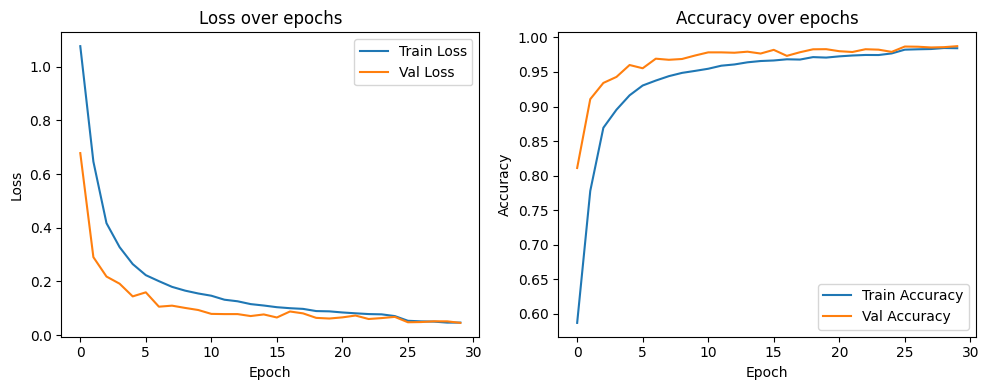

In [31]:
plt.figure(figsize=(10,4))

# Loss
plt.subplot(1,2,1)
plt.plot(history_bigru.history['loss'], label='Train Loss')
plt.plot(history_bigru.history['val_loss'], label='Val Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(history_bigru.history['accuracy'], label='Train Accuracy')
plt.plot(history_bigru.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [32]:
# Predict on test set
y_pred_probs = model_bigru.predict(X_test_rnn)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Classification Report
print("Classification Report (BiGRU):\n")
print(classification_report(
    y_true, y_pred,
    target_names=["N", "S", "V", "F", "Q"],
    digits=4
))

352/352 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step
Classification Report (BiGRU):

              precision    recall  f1-score   support

           N     0.9952    0.9896    0.9924      9059
           S     0.8433    0.9101    0.8754       278
           V     0.9641    0.9654    0.9648       723
           F     0.7978    0.8875    0.8402        80
           Q     0.9709    0.9874    0.9791      1115

    accuracy                         0.9852     11255
   macro avg     0.9143    0.9480    0.9304     11255
weighted avg     0.9857    0.9852    0.9853     11255



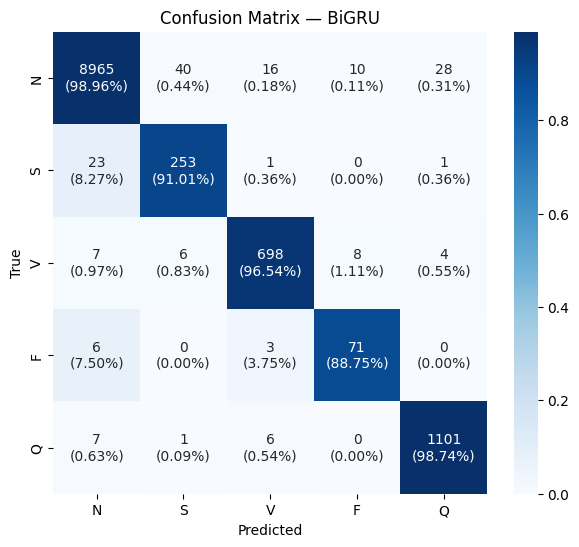

In [33]:
# Confusion matrix
cm_counts = confusion_matrix(y_true, y_pred)
cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

labels = np.asarray([
    [f"{count}\n({percent*100:.2f}%)" for count, percent in zip(row_counts, row_norm)]
    for row_counts, row_norm in zip(cm_counts, cm_norm)
])

plt.figure(figsize=(7,6))
sns.heatmap(cm_norm, annot=labels, fmt="", cmap="Blues",
            xticklabels=["N", "S", "V", "F", "Q"],
            yticklabels=["N", "S", "V", "F", "Q"])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — BiGRU")
plt.show()

##**Using rolling window segments**

###**BiLSTM**

###**BiGRU**